In [1]:
#!pip install --upgrade pip setuptools wheel
#!python -m pip install opencv-python
#!pip install matplotlib
#!pip freeze
#!pip install opencv-python-headless
#!pip install scikit-image
!pip install -U scikit-fuzzy


Defaulting to user installation because normal site-packages is not writeable


In [7]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from os import sep
from os.path import join
from skimage.feature import blob_dog, blob_log, blob_doh
import skfuzzy as fuzz

### IMAGE PROCESSING - PREPROCESSING

In [8]:
#https://github.com/MujtabaAhmad0928/SCRS/blob/fe2f6a7ed9fd1897f8c47da509b2c8a399ea4910/preprocessing.py
def hair_removal_BH(matrix, kernel_size = 17):
    # grayscale
    gray = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY )
    # blackhat 
    kernel = cv2.getStructuringElement(1,(kernel_size,kernel_size))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    # threshold
    ret,th = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    # impainting
    output = cv2.inpaint(matrix, th, 1, cv2.INPAINT_TELEA)
    return output

# RELEVANT
# hairs near the edge of the image are not fully removed

In [9]:
# from bansal paper laplacian of gaussian + top hat morphology
# NOT FINISHED!!!!!!
def hairRemoval_LoG_THM(matrix, ksize = 3, kernel_size = 17, filterSize = (11, 11)):
    # 1. grayscale
    gray = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY)
    
    # 2. laplacian of gaussian
    # steps are blurring,
    #           laplacian,
    #           zero_crossing,
    #           threshold zero crossing to extract strong edges
    ddepth = cv2.CV_16S
    blur = cv2.GaussianBlur(gray, (ksize, ksize), 0)
    lp = cv2.Laplacian(blur, ddepth, ksize=ksize)
    # converting output back to uint8
    log = cv2.convertScaleAbs(lp)

    # 3. closing and dilation
    kernel = cv2.getStructuringElement(1,(kernel_size,kernel_size))
    close = cv2.morphologyEx(log, cv2.MORPH_CLOSE, kernel)
    dil = cv2.dilate(close, kernel)
    
    # 4. top-hat transformation   
    kernel_th = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                          filterSize)
    
    tophat = cv2.morphologyEx(dil, 
                              cv2.MORPH_TOPHAT,
                              kernel_th)
    # 5. otsu
    #thresh = cv2.threshold(sharp, 0, 255, cv2.THRESH_OTSU )[1]
    # 6. erosion and closing
    # 7. impainting
    
    return log, close, dil, tophat

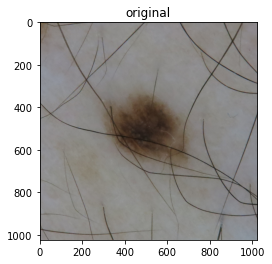

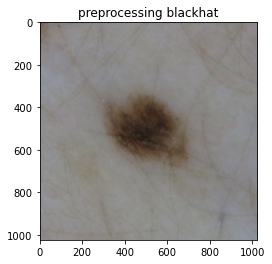

In [85]:
FOLDER_DIR = "/home/emily/Desktop/CAD/train/"

# img = cv2.imread(join(FOLDER_DIR,"nevus", "nev{}.jpg".format("03178")))
img = cv2.imread(join(FOLDER_DIR, "others", "{}.jpg".format("bkl00160")))
# 00656 02056 01831 00547 02237  02462 02655  03178 03284   04438  05209 bcc00220 bcc00242
# 04762 04176 cute
# 00246 05464 02758 02462 02379 shity
# 03863 finger
# others ack00291 ack00363 bcc00001 bc00103 ack00028 ack00180 ack00322 bcc00221 bcc00271
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

nevus = np.array(img_rgb)
plt.imshow(img_rgb)
plt.title('original')
plt.show()

output_bh = hair_removal_BH(img)

plt.imshow(cv2.cvtColor(output_bh, cv2.COLOR_BGR2RGB))
plt.title('preprocessing blackhat')
plt.show()


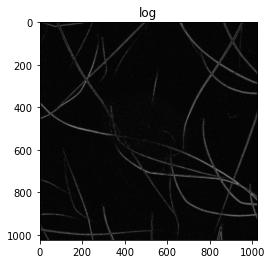

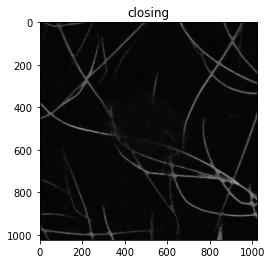

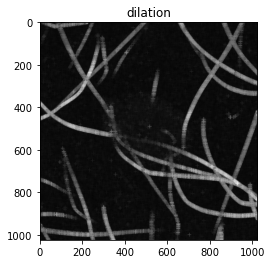

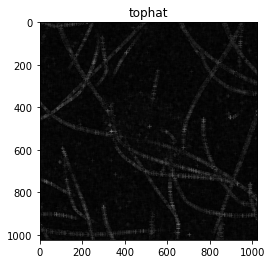

In [86]:
# laplacian of gaussian top hat morphological operation
log, close, dil, tophat = hairRemoval_LoG_THM(img)

plt.imshow(log, cmap='gray')
plt.title('log')
plt.show()

plt.imshow(close, cmap='gray')
plt.title('closing')
plt.show()

plt.imshow(dil, cmap='gray')
plt.title('dilation')
plt.show()

plt.imshow(tophat, cmap='gray')
plt.title('tophat')
plt.show()

# SEGMENTATION

K-means

[6.519258e-09 1.000000e+00]


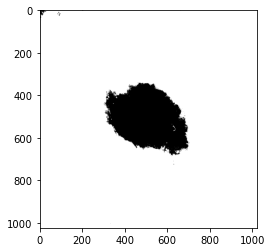

In [87]:
# color space change
hairless = cv2.cvtColor(output_bh, cv2.COLOR_BGR2RGB)
# reshape the image to be a list of pixels
data = hairless.reshape((hairless.shape[0] * hairless.shape[1], 3))
data = np.float32(data)

# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS

# Apply KMeans
compactness,labels,centers = cv2.kmeans(data,2,None,criteria,10,flags)

centers = np.uint8(centers)
res = centers[labels.flatten()]
res2 = res.reshape((hairless.shape))

gray = cv2.cvtColor(res2, cv2.COLOR_RGB2GRAY)

mask = cv2.normalize(gray, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#mask = gray / np.max(gray)


plt.imshow(mask, cmap='gray')

print(np.unique(mask))

fuzzy c-means 

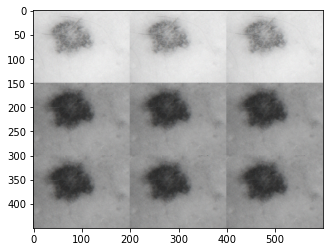

In [12]:
def change_color_fuzzycmeans(cluster_membership, clusters):

    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

def imclearborder(imgBW):

    # Given a black and white image, first find all of its contours
    radius = 2
    imgBWcopy = imgBW.copy()
    image, contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]    

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

#### bwareaopen definition
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    image, contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy      

def imfill(im_th):
    
    im_floodfill = im_th.copy()
    # Mask used to flood filling.
    
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    
    return im_out



ncenters = 2

hairless = cv2.cvtColor(output_bh, cv2.COLOR_BGR2RGB)
# reshape the image to be a list of pixels
data = hairless.reshape((hairless.shape[0] * hairless.shape[1], 3))
data = np.float32(data)

cntr, u_fonc, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data, ncenters, 2, error=0.005, maxiter=1000, init=None)

fcmimg = change_color_fuzzycmeans(u_fonc, cntr)

fcmimg = np.reshape(fcmimg, hairless.shape).astype(np.uint8)

plt.imshow(fcmimg)

# ret, seg_img = cv2.threshold(fcmimg,np.max(fcmimg)-1,255,cv2.THRESH_BINARY)



# bwfim1 = bwareaopen(seg_img, 100)
# bwfim2 = imclearborder(bwfim1)
# bwfim3 = imfill(bwfim2)

# plt.imshow(bwfim3)
# plt.title(name)

# FEATURES EXTRACTION

## ABCD Rule

commonly used feature extraction method from dermoscopic images is based on the ABCD rule of dermatoscopu nachbar et al 1994.  this method consider 4 criteria: 

- asymmetry: if you draw a like through the half of the mole and the halfs are different. its asymetrical
- border structure
- color variation
- diameter of skin lesion.

inspiration for code from

https://github.com/sohum2002/melanoma-detection/blob/master/melanoma/feature_extraction/asymmetry_index.py
https://github.com/hadikhanhk786/melanoma-detection-python/blob/master/src/Lesion.py
https://github.com/RCharradi/Melanoma-detection-from-dermoscopy-images-

 ### ASYMMETRY


centroid  (502.54654050063755, 506.71344205086905)
[6.519258e-09 1.000000e+00]


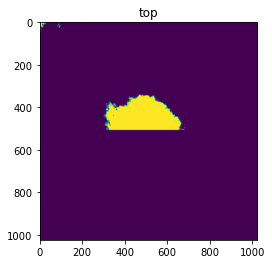

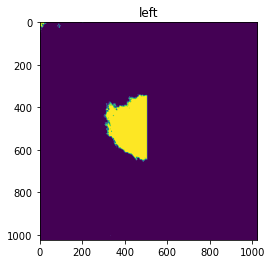

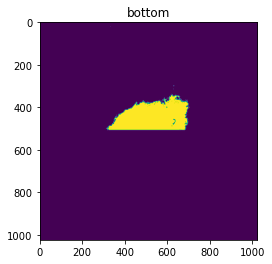

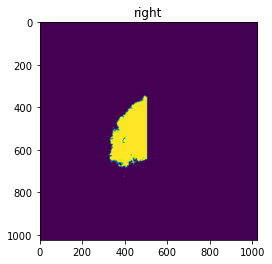

32842.0
52990.0
32285.0
51801.0
symmetry  0.378486083562948


In [88]:
# https://github.com/sohum2002/melanoma-detection/blob/master/melanoma/feature_extraction/asymmetry_index.py

def checkOverlap(shape1, shape2):
    #Find the accuracy of symmetry
    all_pixels = 0.
    correct = 0.
    wrong = 0.

    for i in range(shape1.shape[0]):
        for j in range(shape1.shape[1]):

            curr_pixel1 = (shape1[i][j])
            curr_pixel2 = (shape2[i][j])

            if(curr_pixel1 or curr_pixel2):
                all_pixels += 1
                if(curr_pixel1 and curr_pixel2):
                    correct += 1
                else:
                    wrong += 1

    return correct, wrong, all_pixels

def asymmetry(matrix, mask):
    
    # 0. variables
    x = []
    y = []
    top  = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=bool)
    left = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=bool)
    bottom = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=bool)
    right = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=bool)
    
    # 1. grayscale
    # gray = cv2.cvtColor(matrix, cv2.COLOR_RGB2GRAY)
    gray = mask
    
    # 2. find the center of the image
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            if (gray[i][j] != 1):
                x.append(j)
                y.append(i)
    
    # centroid = ( gray.shape[0] / 2, gray.shape[1] / 2) # need to change if segmentation maskk
    centroid = (sum(x) / len(x), sum(y) / len(y))
    print('centroid ', centroid)
    
    print(np.unique(gray))
    
    # 3. split top/down images
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            if (gray[i][j] < 1):
                if (i < centroid[1]):
                    top[i][j] = True
    
    plt.imshow(top)
    plt.title('top')
    plt.show()
    
    # 4. split left/right images
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            if (gray[i][j] < 0.95):
                if (j < centroid[0]):
                    left[i][j] = True
    
    plt.imshow(left)
    plt.title('left')
    plt.show()
    
    # doing for flip top/down images
    flipped_ud = np.flipud(gray)
    
    for i in range(flipped_ud.shape[0]):
        for j in range(flipped_ud.shape[1]):
            if(flipped_ud[i][j] < 0.95):
                if(i < centroid[1]):
                    bottom[i][j] = True
    
    plt.imshow(bottom)
    plt.title('bottom')
    plt.show()
    
    # doing for flip left/right to get the right part
    flipped_lr = np.fliplr(gray)
    
    # performing splitting for top/down images
    for i in range(flipped_lr.shape[0]):
        for j in range(flipped_lr.shape[1]):
            if(flipped_lr[i][j] < 0.95):
                if(j < centroid[0]):
                    right[i][j] = True

    plt.imshow(right)
    plt.title('right')
    plt.show()
    
    correct_TB, wrong_TB, all_TB = checkOverlap(top, bottom)
    correct_LR, wrong_LR, all_LR = checkOverlap(left, right)
    
    print(correct_TB)
    print(all_TB)
    print(correct_LR)
    print(all_LR)
    
    return 1- sum([correct_TB / all_TB, correct_LR / all_LR]) / 2


result_asym = asymmetry(mask, mask)

print('symmetry ', result_asym)

In [ ]:
def asymmetry(matrix, mask):
    

# MACHINE LEARNING